# Intro to machine learning using Support Vector Machines
* js (jserences@ucsd.edu), June 2022 for CSHL

## Machine learning, or pattern recognition, refers to a large set of tools that are used in many areas of research where you are trying to determine if information is encoded in the pattern of responses across multiple variables. As we'll see below, this sounds a lot more complex it really is, but there are definitely rules that are important to learn and to follow!

* To the extent that there is information in a pattern of measured responses, then the pattern recognition algorithm will be able to successfully assign different "test" examplars into their correct classes.
* If there is no information, then the pattern recognition algorithm will randomly guess and classifation accuracy will be at chance. 
* Note that the 'pattern' part of 'pattern recognition' refers to the fact that we're not just going to use a single variable to predict our outcome measure - we're going  to use the information encoded by a series of variables to make predictions (i.e. a 'multivariate' analysis).
* The multivariate nature of the method is a major advantage as you might infer a null relationship based on univariate methods when in fact there is a very robust relationship that can be revealed by exploiting information encoded in a pattern of measurements. 

<div class="alert alert-info">

**Cross-validation** : To assess the generalizability of a pattern classification algorithm. Cross-validation  refers to the idea that you train your pattern recognition algorithm (henceforth I'll call this a 'classifer') using one set of data, and then you validate, or 'test', the performance of the classifier using a novel set of data that was not part of the training set. The main purpose of cross-validation is to assess the generalizability of your classifier and its ability to correctly categorize novel inputs.

This sounds simple enough - and it is - but its very important to understand the implications of cross-validation...its a good thing that we should all do more often in nearly all contexts where you are fitting a model

**Scenario to understand why...** :

Suppose you did an experiment that had 500 trials of stimulus type A and 500 trials of stimulus type B and you measured the response on each trial in 100 neurons. 

Then, to figure out how well the neural data respond systematically to changes in stimulus parameters, you  fit a multivariate regression model to see how much variability in the stimulus is accounted for by changes in neural activity (i.e. you compute something akin to a R^2 value to quantify goodness of fit). Suppose you run this analysis on all 1,000 trials and you get your R^2 value and its nice and high - like .75 or so. You might be really happy with this, however, since you fit **all** of the data in your model, you are almost certainly overestimating how good the model is at accounting for the relationship between the two factors because your dependent variables  (your measured neural responses) are corrupted by noise, and this noise is idiosyncratic in the sense that if you were to perform the experiment again, you'd get 1000 different measurements that were similar to the first 1000, but corrupted by different noise. 

As a result, when you fit your model to **all** of the data, the resulting coeffecients will reflect the true 'signal' in the data AND the idiosyncratic noise that was measured along with the signal. In effect, your model learns the relationship between the independent variable and the (signal + noise). This occurs because your model has no a priori means of separating out signal and noise - it just gets a measure of neural responses that were evoked by each stimulus, and the model is simply relating those measurements to the independent variables. This is referred to as 'overfitting', and is exacerbated by small data sets (where the signal is not likely to emerge from the noise due to the small sample size) and when you have a model that has lots of free parameters (more free parameters means that the model can more flexibly account for random variations in the data...i.e. noise).  

So - what to do? Instead of fitting the model to all the data and assessing the goodness of fit, you could use cross-validation to estimate **prediction accuracy**. In our example above, you could train your classifer using 400/500 of the trials associated with each stimulus set (so 800 trials total), and then 'test' the classifer's performance at guessing the correct stimulus class using the remaining 200 trials (100 associated with each stimulus). 

Then you could permute this train/test procedure several times, each time holding-out a different set of 800 trials to train the classifer and 200 trials to test the performance of the classifier. 
    
Here is the cool part: if your model is super flexible it might be able to learn the idiosyncratic noise in the training data, and you might even have a reasonable looking R^2 value based on your training data. However, your ability to classify novel examplars from the test set will be at chance becuase your model just learned the random noise in the training set and there was no consistent 'signal' that could actually discriminate between conditions. 

So, the use of cross-validation can protect against overly optimistic assessments of model fit due to 'overfitting', and also enables you to assess the generalizability of the model to classify novel exemplars. The degree to which a classifer generalizes to correctly predict novel stimuli is really  then a measure of how much real signal - or information - there is in your data about the different examplars that you're trying to classify.
</div>

<div class="alert alert-info">

**Out of set prediction**: similar motivation as above with cross-validation, but with out of set prediction you don't repeatedly train and test using folds of the same data set. Instead, you have one set of data that only serves as the training set, and another that serves as the test set (hence the name "out of set prediction"). This can be a powerful approach, especially if one training set can be generalized to several test data sets. In practice choosing cross-validation or out of set prediction often depends on how you set up the experiment and if you included conditions that were specifically designed to serve only as the training set.
</div>

## Overview - we'll cover classification using an Support Vector Machine (or SVM). There are TONS of different algorithms and approaches out there, but this is a common one and will help to build an intuition about how classifiers work
* Using a SVM, we don't fit all the data from each condition, instead we draw a boundary (line, plane, or hyperplane) that is maximally far away from the data points in each set that are close to boundary. This is referred to as "maximizing the margin" and the SVM is therefore a "maximum margin classifier" (although the strictness of this can vary a bit...). 
* Link to the sklearn cross-validation manual [here](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

## Start with imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Support vector classifier: scikit learn has all kinds of good stuff for this...
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score

# also define the default font we'll use for figures.
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 20}

# then set the figure attributes
plt.rc('font', **font)

## First lets set up some code to generate fake data for us to classify
* We'll write a function that we can repeatedly call to generate data from two variables measured in two different experimental conditions. 
* In this example, we'll have two variables (e.g. neurons, voxels, etc), and two experimental conditions.
* We want to see if the **pattern** of responses across the two variables systematically varies across conditions and if we can train a SVM to learn these patterns.

In [7]:
def gen_data(num_data_pnts, mu_c1, mu_c2, plot):
    """

    Input:  num_data_pnts = number of experimental trials, must be even!
            mu_c1, mu_c2 = each is a 2 element array that sets the mean of each variable in each condition
            plot = produce a scatter plot of the data when it is generated? 
    """

    # generate some random data drawn from a normal
    
    # c1_data is response of the neurons 
    # in the first condition, and c2_data is the response in the second condition
    
    # first set up data for condition 1, with a different mean response in each neuron (defined by mu_c1)
    tmp1 = np.random.randn(num_data_pnts,1) + mu_c1[0]
    tmp2 = np.random.randn(num_data_pnts,1) + mu_c1[1]
    
    # horizontally concatenate the data
    # will give you a num_data_pnts x 2 matrix
    c1_data = np.hstack((tmp1, tmp2))
    
    # then set up data for condition 2, with a different mean response in each neuron (defined by mu_c2)
    tmp1 = np.random.randn(num_data_pnts,1) + mu_c2[0]
    tmp2 = np.random.randn(num_data_pnts,1) + mu_c2[1]
    
    # horizontally concatenate the data
    # will give you a num_data_pnts x 2 matrix
    c2_data = np.hstack((tmp1, tmp2))
    
    if plot:
        # plot the data...
        plt.scatter(c1_data[:,0], c1_data[:,1], color='b')
        plt.scatter(c2_data[:,0], c2_data[:,1], color='r')
        plt.xlabel('Variable 1')
        plt.ylabel('Variable 2')
        plt.legend(['Condition 1', 'Condition 2'], loc='best', fontsize='x-small')
        plt.show()
    
    return c1_data, c2_data

## Now make some data...

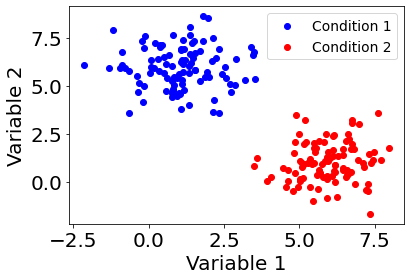

In [12]:
# seed the random num sequence so that we get consistent results every time!
# and for the purposes of this tutorial, seed with 8 cause it will make the figs
# look pretty below when we start learning about SVMs
np.random.seed(8)

# try out our function...
# mu_c1 is the mean response in each variable under the first experimental condition
# mu_c2 is the mean response in each variable under the second experimental condition
mu_c1 = np.array([1,6])
mu_c2 = np.array([6,1])

# how many data points do we want to generate for each condition?
N = 100

# now call our data generating function and return data from each condition in d0 and d1
d_c1, d_c2 = gen_data(num_data_pnts=N, mu_c1=mu_c1, mu_c2=mu_c2, plot=1)

## A few things to note about this data set - univariate vs multivariate
* You can clearly see that our two variables respond differently under our two experimental conditions - they carry information that discriminates between the conditions
* However, if you were to average across both variables and report univariate summary statistics, there would be essentially no difference between conditions and you'd think you had a null result!

In [13]:
# same response (within noise given 100 random samples...numbers would converge with higher N)
print('Mean response in condition 1 across neurons: ', np.mean(d_c1[:]))
print('Mean response in condition 2 across neurons: ', np.mean(d_c2[:]))

Mean response in condition 1 across neurons:  3.513081304480811
Mean response in condition 2 across neurons:  3.473680129135825


## Now think about drawing a decision boundary that will separate these two classes (i.e. a boundary that will separate data from these two experimental conditions)
* In the case of 2D data like this, then we're looking to draw a line that separates the two classes
* In higher dim data sets, then we're trying to find the plane (3D) or hyperplane (ND). 
* However, the logic is the same in all cases
* **Important**: Note that there are many lines that can perfectly separate these two classes!
* Given this, how do we select the optimal boundary? 

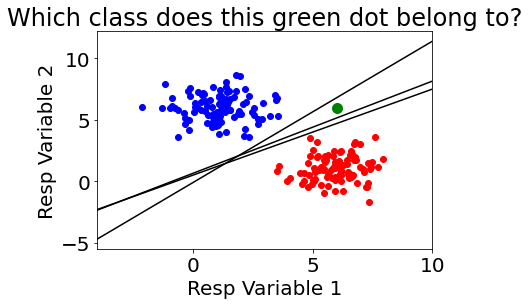

In [14]:
# define some lines that separate these two classes

# start with an x-axis that covers our space
x_range = -4,10
x_vals = np.linspace(x_range[0], x_range[1])

# plot data - note the abbreviated 'color' call
plt.scatter(d_c1[:, 0], d_c1[:, 1], c='b')
plt.scatter(d_c2[:, 0], d_c2[:, 1], c='r')
plt.xlabel('Resp Variable 1')
plt.ylabel('Resp Variable 2')

# draw some lines...y = ax+b...
for a, b in [(.75, 0.65), (.7, 0.5), (1.15, -.1)]:
    plt.plot(x_vals, a * x_vals + b, '-k')

plt.xlim(x_range[0], x_range[1])

# add an extra data point to make a point about arbitrarily drawing separating boundaries...
plt.title('Which class does this green dot belong to?')
plt.plot(6, 6, 'o', c='g', markersize=10)
plt.show()

## Given the ambiguity here about where to draw the boundary, SVMs will instead create a line (or plane or hyperplane) with a margin that extends up to the nearest points in each data set.
* Note that I'm hardcoding this plot just to make a point...we'll actually compute all this for reals in a minute.

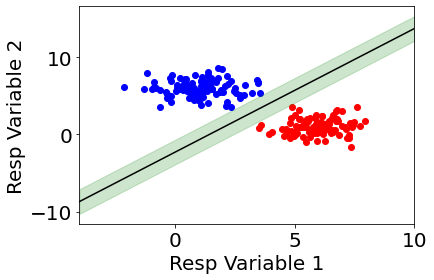

In [15]:
# an x-axis that covers our space
x_range = -4,10
x_vals = np.linspace(x_range[0], x_range[1])

# plot data - note the abbreviated 'color' call
plt.scatter(d_c1[:, 0], d_c1[:, 1], c='b')
plt.scatter(d_c2[:, 0], d_c2[:, 1], c='r')
plt.xlabel('Resp Variable 1')
plt.ylabel('Resp Variable 2')

# plot a sample line + margin that maximizes distance between boundary point
y_vals = 1.6 * x_vals + -2.3
plt.plot(x_vals, y_vals, '-k')
plt.fill_between(x_vals, y_vals + 1.6, y_vals - 1.6,
                 color='g', alpha=0.2)
    
plt.xlim(x_range[0], x_range[1])
plt.show()

## So above was just a hand-drawn version of what an SVM is trying to accomplish. Now we can actually implement to see how it works

In [16]:
# first lets assign parts of our data to training and testing sets
percent_train_set = .9
r,c = d_c1.shape  # get the shape of our data sets (they are the same size, so can just do this once)
trn_length = int(np.round(percent_train_set * r, 0))

# now assign the first 90% of the trials to the training set...
# we'll stack up the first 90% from the first condition on top 
# of the 90% of data from the second condition
trn_data = np.vstack((d_c1[0:trn_length,:], d_c2[0:trn_length,:]))

# and the last 10% of the trials get stacked to make the test set...
tst_data = np.vstack((d_c1[trn_length:,:], d_c2[trn_length:,:]))

# last generate a vector that labels the data from each trial
# as belonging to condition 1 or condition 2
trn_labels = np.hstack((np.zeros(trn_length), np.ones(trn_length))).T
tst_labels = np.hstack((np.zeros(r-trn_length), np.ones(r-trn_length))).T

# The SVC was imported earlier via the sklearn module
# so we can train the classifer using our data.

# first specify the model...linear SVM with a criterion value of 1
# if C is big, that will enforce a hard margin...if C is small, it 
# will allow some leakage of points over the margin.
model = SVC(kernel='linear', C=1)

# then fit the model to our training data by passing in the data matrix + a list of labels that denotes the 
# experimental condition for each trial
model.fit(trn_data, trn_labels)

SVC(C=1, kernel='linear')

## Then eval the model over the span of the data

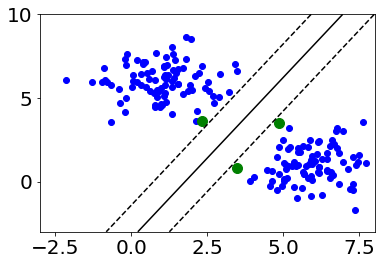

In [17]:
# create grid to evaluate model - just give it a x and y range 
# that encompasses all of our data points
x = np.linspace(-3, 8, 100)
y = np.linspace(-3, 10, 100)

# use meshgrid to eval function on a 2D grid
# rectangular grid out of an array of x values and an array of y values.
# basically, every combination of the x and y points.
X, Y = np.meshgrid(x,y)

# stack up the data into a 10000,2 matrix of all X,Y coordinates
XY = np.vstack([X.ravel(), Y.ravel()]).T

# compute the decision function across all points 
# that span the space that the model is fitting
# take the decision function and reshape to the size of data
DF = model.decision_function(XY).reshape(X.shape)

# plot the data
plt.scatter(trn_data[:, 0], trn_data[:, 1], c='b')

# grab the handle for the axis
axis = plt.gca()

# plot the decision boundary and the margins on either side of boundary
axis.contour(X, Y, DF, colors='k',
           levels=[-.8, 0, .8],
           linestyles=['--', '-', '--'])

# plot support vectors as points in the figure
axis.scatter(model.support_vectors_[:, 0],
           model.support_vectors_[:, 1],
           s=100,c='g');

plt.show()

## The highlighted points are the 'support vectors' and are the points that define the fit of the boundary that best separates the data associated with each experimental condition. 
* You can think of these points as 'pivots' or leverage points that constrain the fit of the boundary
* Notice also that only the position of the support vectors matters here. The positions of the other points, so long as they are one side or the other of the margin, do not matter. 
* This stands in contrast to other common linear classifiers based on the Mahalanobis distance (and other distance metrics) that model the entire distribution of data in each class...the SVM only cares about maximizing the margin along the boundary 

## Now let's give it a try like we would with a real data set...
* define a training set
* define a test set
* fit model to training set
* apply to each "trial" in the test set
* compute classification accuracy!

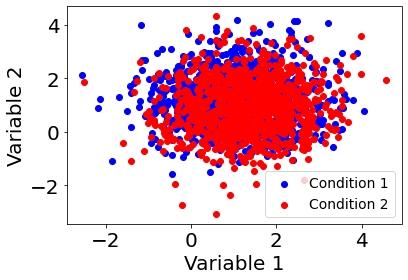

In [18]:
# seed the random num sequence so that we get consistent results every time!
np.random.seed(8)

# try out our function...
# mu_c1 is the mean response in each neuron under the first experimental condition
# mu_c2 is the mean response in each neuron under the second experimental condition
mu_c1 = np.array([1,1.15])
mu_c2 = np.array([1.3,1])

# how many data points do we want to generate for each condition?
N = 1000

# now call our data generating function and return data from each condition in d0 and d1
d_c1, d_c2 = gen_data(num_data_pnts = N, mu_c1 = mu_c1, mu_c2 = mu_c2, plot = 1)

In [19]:
# now lets generate a training set and a test set. We'll use 70% of our data as a training set
# and leave 30% as a test set
r,c = d_c1.shape  # get the shape of our data set (and d_c2 is the same size, so just need to get one of these)
trn_length = int(np.floor(.7*r))

In [20]:
# now assign the first 70% of the trials to the training set...
# we'll stack up the first 70% from the first condition on top 
# of the 70% of data from the second condition
trn_data = np.vstack((d_c1[0:trn_length,:], d_c2[0:trn_length,:]))

# and the last 30% of the trials to the test set...
tst_data = np.vstack((d_c1[trn_length:,:], d_c2[trn_length:,:]))

In [21]:
# last its helpful to generate a vector that labels the data from each trial
# as belonging to condition 1 or condition 2
trn_labels = np.hstack((np.zeros(trn_length), np.ones(trn_length)))
tst_labels = np.hstack((np.zeros(r-trn_length), np.ones(r-trn_length)))

In [22]:
# then train the model - Play with C a bit here...
model = SVC(kernel='linear', C=1)
model.fit(trn_data, trn_labels)

SVC(C=1, kernel='linear')

In [23]:
# then classify the test trials
class_labels = model.predict(tst_data)

# Then just compute our classification accuracy by comparing the predicted labels to the ground truth
class_acc = np.sum(class_labels==tst_labels) /  tst_data.shape[0]
print('Classification accuracy with a SVM is: ', class_acc)

# or use built in....takes actual and then predicted labels...
accuracy_score(tst_labels, class_labels)

Classification accuracy with a SVM is:  0.5766666666666667


0.5766666666666667

## How to evaluate significance?
* randomization testing!
* recompute classification accuracy a bunch of times (e.g., 1000 or more) with scrambled labels in the test set
* that generates a distribution of classification accuracies under the *null* hypothesis that experimental condition has no meaning!

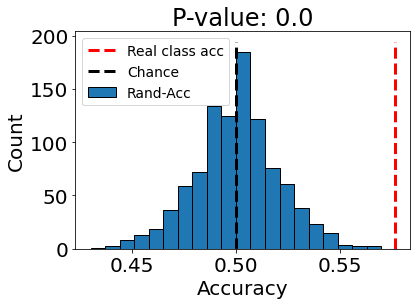

In [25]:
num_rands = 1000

rand_acc = np.full(num_rands, np.nan)

# loop! scramble labels each time
for r in np.arange(num_rands):
    
    # shuffle in place! this is undoable
    np.random.shuffle(tst_labels)
    
    # Then just compute our classification accuracy by comparing the predicted labels to the ground truth
    rand_acc[r] = np.sum(class_labels==tst_labels) /  tst_data.shape[0]

# simplest way to get a feel for how likely your data are under the null
pval = np.sum(rand_acc>class_acc)/num_rands

# plot...
plt.hist(rand_acc, 20, label='Rand-Acc', edgecolor='black')

ylim = plt.ylim()

# plot real data - notice the 'list' hack here!
plt.plot(2*[class_acc], ylim, '--r', linewidth=3, label='Real class acc')

# plot chance
plt.plot(2*[1. / 2], ylim, '--k', linewidth=3, label='Chance')
plt.ylabel('Count')
plt.xlabel('Accuracy')
plt.legend(loc='best', fontsize='x-small')
plt.title('P-value: ' + str(pval))

plt.show()

## Or do randomization using scikit-learn built ins...
* Doing more cross validation folds here so final classification accuracy will be a little different compared to above example where we just did one fold
* Note: sklearn will compute p-values using the following convention: 

`(C + 1) / (number_of_permutations + 1)`

Where C is the number of permutations whose score >= the true score. As a result, the lowest possible p-value will be: 

`1 / (number_of_permutations + 1)`

Classification score 0.5675 (pvalue : 0.000999000999000999)


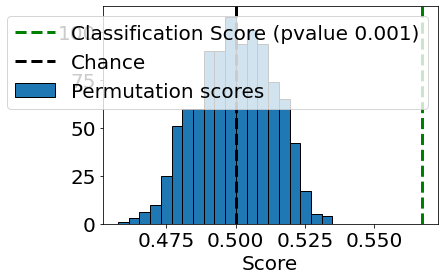

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

# stack up the data from our two conditions
data = np.vstack((d_c1, d_c2))

# make trial labels
r,c = data.shape
labels = np.hstack((np.zeros(int(r/2)), np.ones(int(r/2))))

svm = SVC(kernel='linear')

# splits data into n_splits groups, then uses all but 1 for training and the remaining one for testing
cv = StratifiedKFold(n_splits=4)

score, permutation_scores, pvalue = permutation_test_score(
    svm, data, labels, scoring="accuracy", cv=cv, n_permutations=250, n_jobs=8)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

# Plot a histogram of permutation scores
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')

ylim = plt.ylim()

plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % np.round(pvalue,4) )

plt.plot(2 * [1. / 2], ylim, '--k', linewidth=3, label='Chance')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()